In [1]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from pylab import figure, cm
import random
from jax import grad, hessian, jit, vmap
import time
from IPython.display import clear_output


m = 1.0
omega = 1.0
# lam = 0
hbar = 1.0
R = .5
# number of parameters in the ansatz
num_params = 1
# number of coordinates in the ansatz
num_coords = 1
times = []
seed = 5
cfactor = .439911

# define the wavefunction ansatz
@jit 
def psi(coords, params):
    #return jnp.exp(-.5 *(coords[0]**2 + coords[1]**2))*(params[0]+params[1]*(coords[0] - coords[1]) + params[2]*(coords[0] - coords[1])**2)
    return jnp.exp(-coords[0]**2 - params[0]*coords[0])

def psi_neg(coords, params):
    return 1/psi(coords, params)
psi_negj = jit(psi_neg)
def logpsi(coords, params):
    return jnp.log(psi(coords, params))
logpsij = jit(logpsi)

h = hessian(psi)
def ddpsi(coords, params):
    return jnp.diagonal(h(coords, params))
    # return h(coords, params)[i][i]

partials = jit(grad(logpsij, argnums=1))

@jit
def V(coords, l):
    return .5 *m* omega**2 * (coords[0]**2 + coords[1] ** 2) + l * jnp.exp(-((coords[0] - coords[1])/R)**2)

def Hpsi(coords, params, l):
    hpsi = Vj(coords, l) * psi(coords, params) - hbar**2/(2*m) * jnp.sum(ddpsi(coords, params))
    return hpsi


def sample(params, num_samples):
    # random.seed(seed)
    outputs = []
    coords_t = np.zeros(num_coords)
    for _ in range(num_samples):
        coords_prime = coords_t + np.random.uniform(-1,1,num_coords)
        if (np.random.uniform(0,1) < psi(coords_prime, params)**2/psi(coords_t, params)**2):
            coords_t = coords_prime
        outputs.append(coords_t)
    return jnp.array(outputs)


# jitted functions
Hpsij = jit(Hpsi)
Vj = jit(V)
# vectorized functions
vgradlogs = vmap(partials, in_axes=(0, None), out_axes=0)
vpsi_neg = vmap(psi_negj, in_axes=(0, None), out_axes=0)
vhpsis = vmap(Hpsij, in_axes=(0, None, None), out_axes=0)
# vboth = vmap(jit(jnp.multiply), in_axes=(0, 0), out_axes=0)
vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)


def avg_energy(params, l , N=10**3):
    # get N sampled points
    samples = sample(params, N)
    # apply the function to every point
    hpsis = vhpsis(samples, params, l)
    psi_neg = vpsi_neg(samples, params)
    psi_neg_times_hpsis = jnp.multiply(psi_neg, hpsis)
    return 1/N * jnp.sum(psi_neg_times_hpsis)

# optimized gradient code, using vectorization and jitted functions 
def vgradient(params, l, N):
    samples = sample(params, N)
    
    gradlogs = vgradlogs(samples, params)
    hpsis = vhpsis(samples, params, l)
    psi_neg = vpsi_neg(samples, params)


    psi_neg_times_hpsis = jnp.multiply(psi_neg, hpsis)
    # now compute the 3 different averages
    energy_exp = 1/N * jnp.sum(psi_neg_times_hpsis)
    # print("Average Energy: " + str(energy_exp))
    gradlogpsi_exp = 1/N * jnp.sum(gradlogs, 0)
    
    # both_exp = 1/N * jnp.sum(jnp.array([(psi_neg_times_hpsis[i] * gradlogs[i]) for i in range(len(samples))]), 0)
    both_exp = 1/N * jnp.sum(vboth(psi_neg_times_hpsis, gradlogs), 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

def gradient(params, N):
    samples = sample(params, N)
    # first compute all used values to decrease recomputation
    gradlogs = [partials(coords, params) for coords in samples]
    
    psi_neg = [1/psi(coords, params) for coords in samples]
    
    hpsis = [Hpsi(coords, params) for coords in samples]
    
    psi_neg_times_hpsis = [(psi_neg[i] * hpsis[i]) for i in range(len(samples))]
    # now compute the 3 different averages
    energy_exp = 1/N * sum([psi_neg_times_hpsis[i] for i in range(len(samples))])
    print("Average Energy: " + str(energy_exp))
    gradlogpsi_exp = 1/N * sum(gradlogs, 0)
    both_exp = 1/N * sum([(psi_neg_times_hpsis[i] * gradlogs[i]) for i in range(len(samples))], 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

def grad_opt(start_params, learning_rate=.1, max_iterations=100, tolerance=.01, N=10**3):
    # pick the starting position
    params = start_params
    hist = []
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        clear_output(wait=True)
        # compute the gradient at that point
        diff = np.asarray((learning_rate * gradient(params, N)))
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

def vgrad_opt(start_params, l, learning_rate=.1, max_iterations=100, tolerance=.01, N=10**3):
    # pick the starting position
    params = start_params
    hist = [start_params]
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        #clear_output(wait=True)
        # compute the gradient at that point
        diff = jnp.asarray((learning_rate * vgradient(params, l, N)))
        if all((abs(val) < tolerance) for val in diff):
            # print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

In [2]:
start = jnp.array([.5])
hist = vgrad_opt(start, l=.1, N=10**3)
optd = hist[-1]
print(optd)
print(avg_energy(optd, l=.1))
energy_exp = 1 + .1 * cfactor
print(energy_exp)

KeyboardInterrupt: 

In [ ]:
# get a contour plot of the wavefunction
size = 100
xmin = -5
xmax = 5
ymin = -5
ymax = 5

X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
Z = [[psi([i, j], optd) for i in X] for j in Y]

[0.90744764 0.04116613 0.00928119]


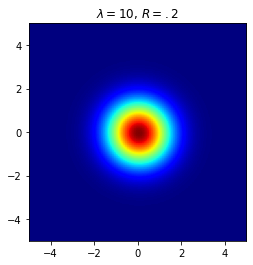

In [ ]:
print(optd)
plt.title(r"$\lambda = 10$, $R = .2$")
plt.imshow(Z,extent=[xmin, xmax, ymin, ymax], cmap=cm.jet, origin='lower')
# plt.contour(X,Y,Z)/
plt.show()

In [ ]:
## get the data for a series of plots with varying lambda levels
lambdas = np.linspace(0, 10, 30)
wfs = []
for i in range(len(lambdas)):
    if i == 0:
        start = jnp.array([.5,.5,.5])
    else:
        start = wfs[i - 1]

    # do the optimization
    hist = vgrad_opt(start, lambdas[i])
    wfs.append(hist[-1])

In [ ]:
# now make a series of plots with all the data
size = 100
xmin = -5
xmax = 5
ymin = -5
ymax = 5
X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
meshes = []

for k in range(len(lambdas)):
    meshes.append([[psij([i, j], wfs[k]) for i in X] for j in Y])

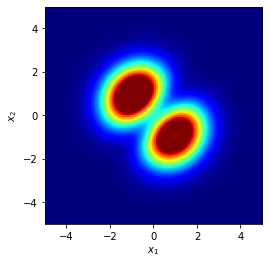

In [ ]:

fig = plt.figure()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
im = plt.imshow(meshes[0], cmap=plt.get_cmap('jet'), extent=[xmin, xmax, ymin, ymax], origin='lower')
# im = plt.contour(X,Y, meshes[0])

def updatefig(j):
    # set the data in the axesimage object
    im.set_array(meshes[j])
    # return the artists set
    return [im]


ani = animation.FuncAnimation(fig, updatefig, frames=range(len(lambdas)), 
                              interval=200, blit=False)
f = r"animation.gif" 
writergif = animation.PillowWriter(fps=5) 
ani.save(f, writer=writergif)


In [ ]:
## plotting lambda vs min energy
energies = []
expected = []
for i in range(len(lambdas)):
    params = wfs[i]
    energy = avg_energy(params, lambdas[i], 10**3)
    energies.append(energy)
    expected.append(1 + lambdas[i] * cfactor)

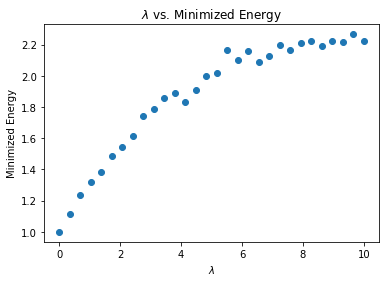

In [ ]:
plt.scatter(lambdas, energies)
# plt.plot(lambdas, expected)
plt.title(r"$\lambda$ vs. Minimized Energy")
plt.xlabel(r"$\lambda$")
plt.ylabel("Minimized Energy")
plt.show()